# Text Analytics

In [1]:
load("review.RData")
library(readr)
library(stargazer)
library(knitr)
library(dplyr)
library(ggplot2)
library(stringr)
library("ggExtra")
library(psych)
library(dplyr)
library(tidyr)
library(purrr)
library(readr)
library(tidytext)
library(widyr)
library(tm)
library(topicmodels)
library(wordcloud)
library(reshape2)
library("ldatuning")
library(SnowballC)

Warning message:
"package 'readr' was built under R version 3.4.4"Warning message:
"package 'stargazer' was built under R version 3.4.4"
Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 

Warning message:
"package 'knitr' was built under R version 3.4.4"Warning message:
"package 'dplyr' was built under R version 3.4.4"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'stringr' was built under R version 3.4.4"Warning message:
"package 'ggExtra' was built under R version 3.4.4"Warning message:
"package 'psych' was built under R version 3.4.4"
Attaching package: 'psych'

The following objects are masked from 'package:ggplo

In [2]:
#Clean the dataset
tidy_rev <- review %>%
  unnest_tokens(word, text) %>% 
  anti_join(stop_words) %>% 
  filter(word != "br") %>% #HTML tag <br /><br /> results in the word "br"
  mutate(word = wordStem(word))
head(tidy_rev)

Joining, by = "word"
Warning message:
"package 'bindrcpp' was built under R version 3.4.4"

rev_id,productId,userId,rating,time,word
1,B003AI2VGA,A141HP4LYPWMSR,3,1182729600,dark
1,B003AI2VGA,A141HP4LYPWMSR,3,1182729600,miracl
2,B003AI2VGA,A328S9RN3U5M68,3,1181952000,worthwhil
2,B003AI2VGA,A328S9RN3U5M68,3,1181952000,stori
2,B003AI2VGA,A328S9RN3U5M68,3,1181952000,hamper
2,B003AI2VGA,A328S9RN3U5M68,3,1181952000,poor


** What is the most common stemmed word in the review? How many times does it occur? **

In [3]:
#Printing top10 words
tidy_rev %>% 
  count(word, sort = TRUE) %>% 
  slice(1:10)

word,n
movi,12575
film,4260
dvd,3379
love,3154
classic,2654
time,1928
excel,1754
fun,1666
bad,1335
awesom,1279


** Plot a 100-word word-cloud. What is the correct size ordering? If it’s not apparent visually, you can check counts to verify. **

word,n
movi,12575
film,4260
dvd,3379
love,3154
classic,2654
time,1928
excel,1754
fun,1666
bad,1335
awesom,1279


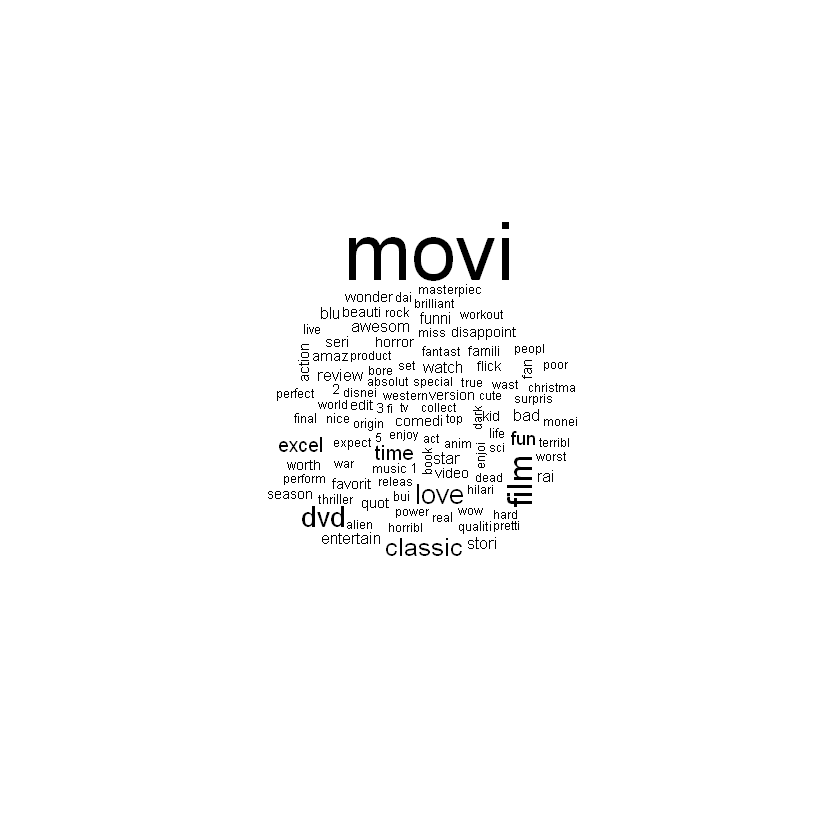

In [4]:
#Drawing word cloud
tidy_rev %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 100))


tidy_rev_wordn<-tidy_rev %>%
  count(word,sort=TRUE)
tidy_rev_wordn[1:20,]

** Perform a sentiment analysis (negative or positive words) and plot a comparison cloud (max words=100). Identify the correct classification. **

Joining, by = "word"


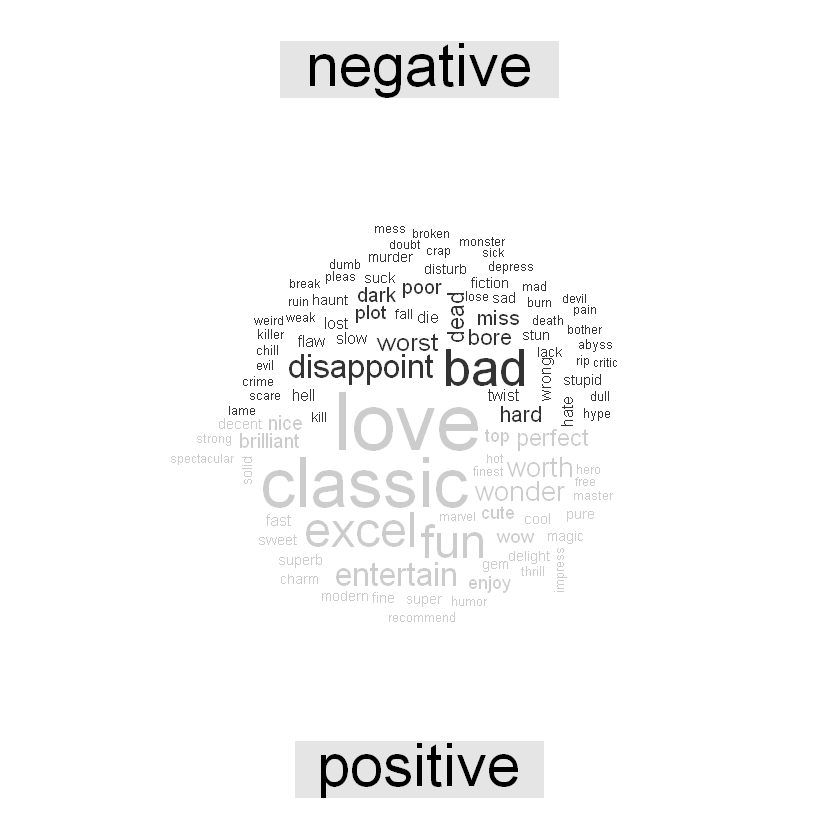

In [5]:
#Draw the 100 words comparison cloud
tidy_rev %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort=TRUE) %>%
  acast(word ~ sentiment, value.var = "n", fill = 0) %>%
  comparison.cloud(colors = c("gray20", "gray80"),
                   max.words=100)

In [6]:
#Create dataset of sentiments for subsetting only the one in questions
x<-tidy_rev %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort=TRUE) 
x[x$word %in% c('thrill', 'hype', 'free',   
                    'gem', 'abyss',    'hell',
                'love', 'classic', 'excel', 'fiction', 'stun', 'plot', 'twist', 'magic', 'decent'),,]

Joining, by = "word"


word,sentiment,n
love,positive,3154
classic,positive,2654
excel,positive,1754
plot,negative,296
decent,positive,237
twist,negative,231
hell,negative,193
gem,positive,184
magic,positive,164
stun,negative,161


** The AFINN lexicon assigns words with a score that runs between -5 and 5, with negative scores indicating **
** #negative sentiment and positive scores indicating positive sentiment. **
** Calculate the affin score of all words for each movie, and plot avg score vs avg rating and sum of scores vs avg rating. **
** Is there a linear relationship in the plots? **

Warning message in brewer.pal(ncol(term.matrix), "Dark2"):
"n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
"

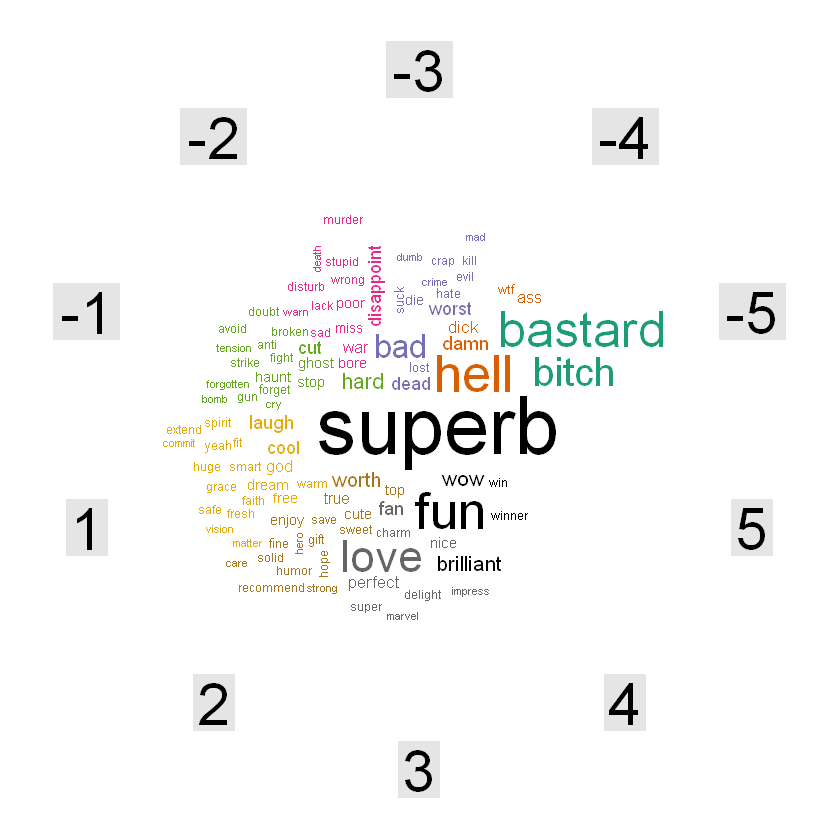

In [7]:
#Get the sentiments
tidy_rev_sentiment <- tidy_rev %>%
  inner_join(get_sentiments("afinn"), by = "word")


#Draw word cloud for sentiments
tidy_rev_sentiment %>%
  count(word, score, sort=TRUE) %>%
  acast(word ~ score, value.var = "n", fill = 0) %>%
  comparison.cloud(max.words=100)

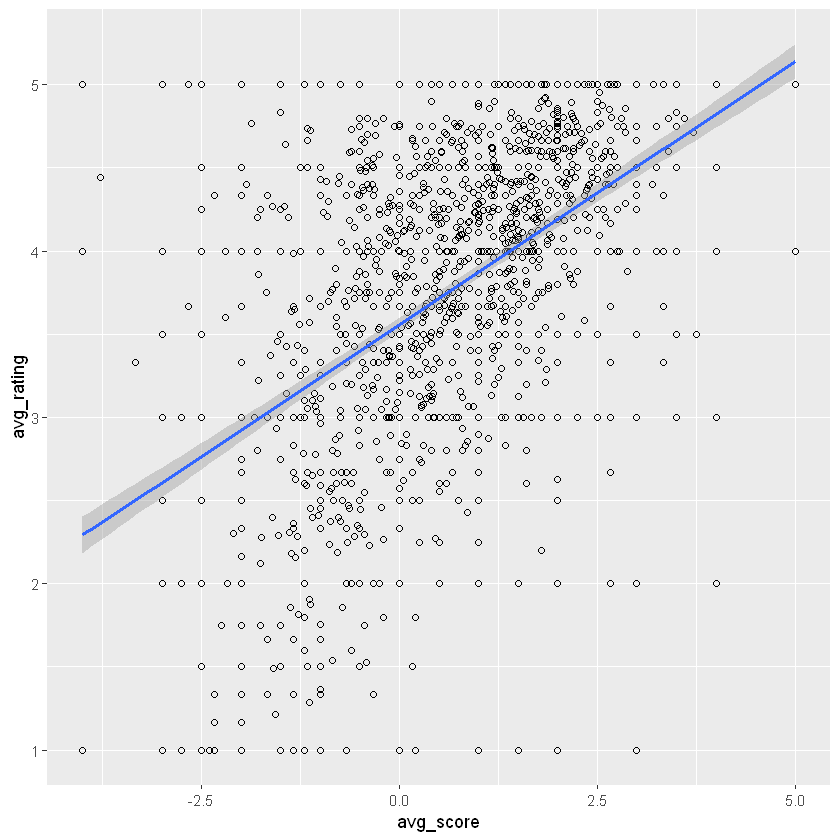

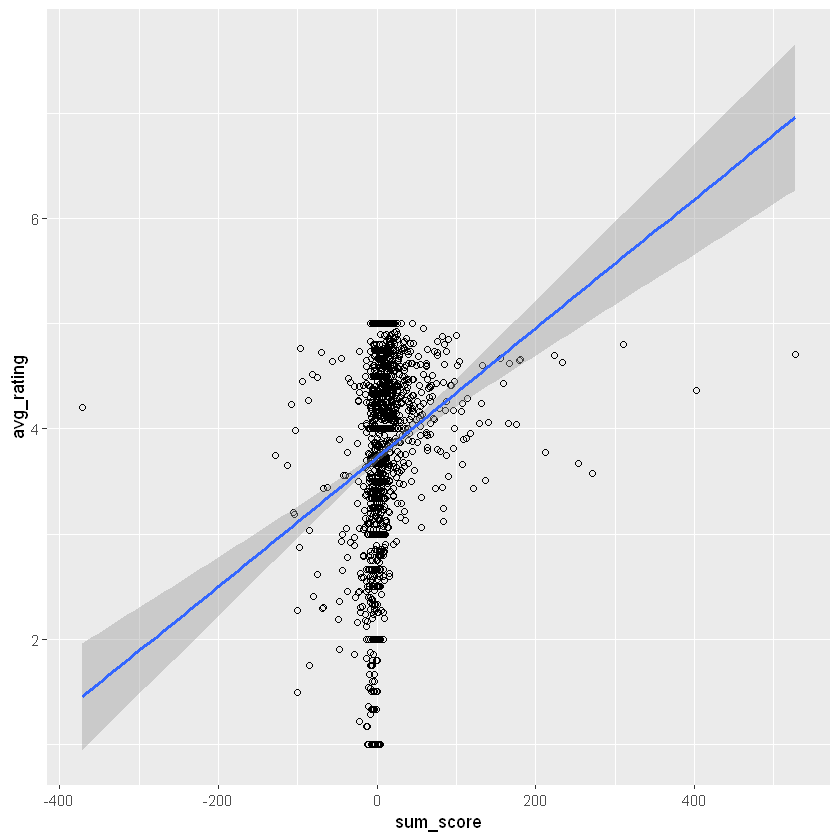

In [8]:
#Q13 draw line between score and rating
tidy_rev_sentiment_prod <- tidy_rev_sentiment %>% 
  group_by(productId) %>% 
  summarise(avg_score=mean(score),
            sum_score=sum(score),
            avg_rating = mean(rating))

ggplot(tidy_rev_sentiment_prod, aes(x=avg_score, y=avg_rating)) +
  geom_point(shape=1) +    # Use hollow circles
  geom_smooth(method=lm,   # Add linear regression line
              se=TRUE)    # Don't add shaded confidence region

ggplot(tidy_rev_sentiment_prod, aes(x=sum_score, y=avg_rating)) +
  geom_point(shape=1) +    # Use hollow circles
  geom_smooth(method=lm,   # Add linear regression line
              se=TRUE)    # Don't add shaded confidence region

** Above shows there is linear relation between avg_rating and avg_score **

**Topic Modeling using LDA. Perform a 4 topic modeling of the data after converting from tidy form, **
** with one-term-per-document-per-row, to a DocumentTermMatrix. Hint: (Use cast_dtm). **
** Use seed=1234 for LDA. Obtain the top 5 terms for each of the 4 topics **

Warning message:
"Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged."

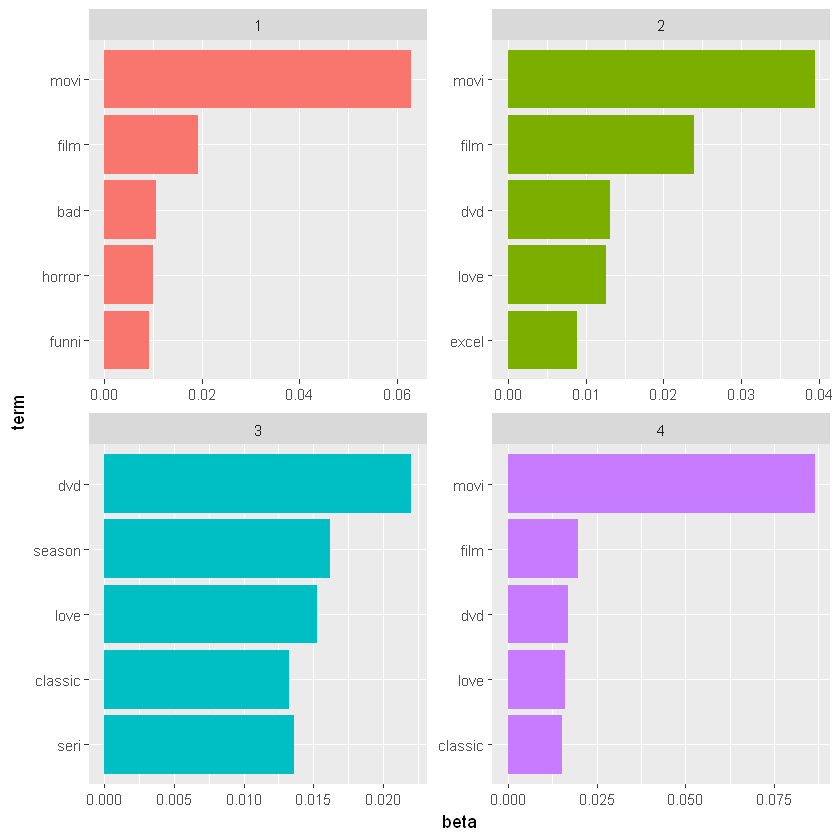

In [9]:
rev_dtm <- tidy_rev %>%
  count(productId, word, sort = TRUE) %>%
  ungroup() %>%
  cast_dtm(productId, word, n)

# 4 topics
product_lda <- LDA(rev_dtm, k = 4, control = list(seed = 1234))

product_topics <- tidy(product_lda, matrix = "beta")

top_terms <- product_topics %>%
  group_by(topic) %>%
  top_n(5, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()